First import all the things and setup the plot things

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import time
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from importlib import reload
import speclite.filters
from scipy.interpolate import interp1d, RegularGridInterpolator as rgi
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from scipy.signal import medfilt, correlate
from numpy.random import poisson, randn
import copy 

SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Initial Setup

Setup the path to the peripheral files and load in the filter objects from speclite

In [2]:
path = '/scr3/dmawet/ETC/'
filters = spectrum.load_filters()

## Telescope Setup

A *telescope* object contains the telecope parameters, the site characteristics and the current conditions. 

In [3]:
keck = telescope.Keck(path=path)
keck.airmass=1.0
keck.water_vapor=1.6
keck.seeing = keck.median_seeing

## Instrument Setup

An _instrument_ object contains both the static instrument parameters, as well as the current observing setup

In [4]:
#Initialize a hispec object and set the current filter
hispec = instrument.hispec(telescope=keck)
hispec.set_current_filter("TwoMASS-J")

#Get the set of wavelengths based on the current instrument setup
wavelengths = hispec.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
hispec.set_observing_mode(3600,1,'TwoMASS-J', wavelengths,mode="off-axis") 

## Generate some Spectra

We can now generate a host spectrum

In [5]:
#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.00,"StarTeff":10000,"StarZ":'-0.0',"StarAlpha":"0.0",
                   "StarRadialVelocity":100*u.km/u.s,
                    "StarVsini":10*u.km/u.s,
                    "StarLimbDarkening":0.8}

#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (path,'TwoMASS-J',5.0,filters,hispec.current_filter)

#Generate the spectrum! (Here we apply a doppler shift and rotationally broaden)
host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,hispec.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=hispec.current_dwvs)


/home/dechever/anaconda3/lib/python3.7/site-packages/speclite/filters.py:1461: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


Plot the Spectrum!

Text(0, 0.5, 'Spectrum [ph / (Angstrom cm2 s)]')

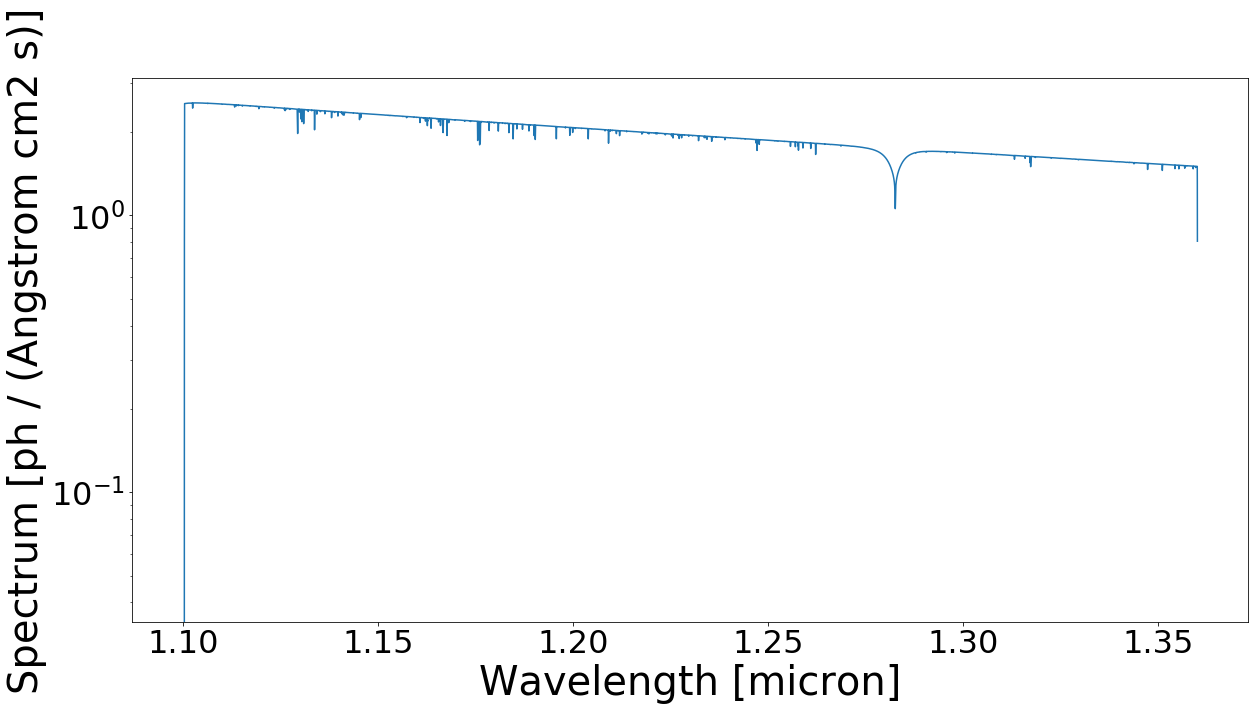

In [6]:
plt.figure(figsize=(20,10))

plt.semilogy(wavelengths,host_spectrum)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(host_spectrum.unit))

Now we can generate a target spectrum as well

In [7]:
obj_properties = {"StarLogg":3.25,"StarTeff":700,"StarRadialVelocity":20*u.km/u.s,"StarVsini":10*u.km/u.s,
                  "StarLimbDarkening":0.9}

obj_user_params = (path,'TwoMASS-K',20,filters,hispec.current_filter)

obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,hispec.current_R,model="Sonora",
                                             user_params=obj_user_params,doppler_shift=True,broaden=True,
                                             delta_wv=hispec.current_dwvs)

/home/dechever/anaconda3/lib/python3.7/site-packages/speclite/filters.py:1461: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


(1e-10, 0.0001)

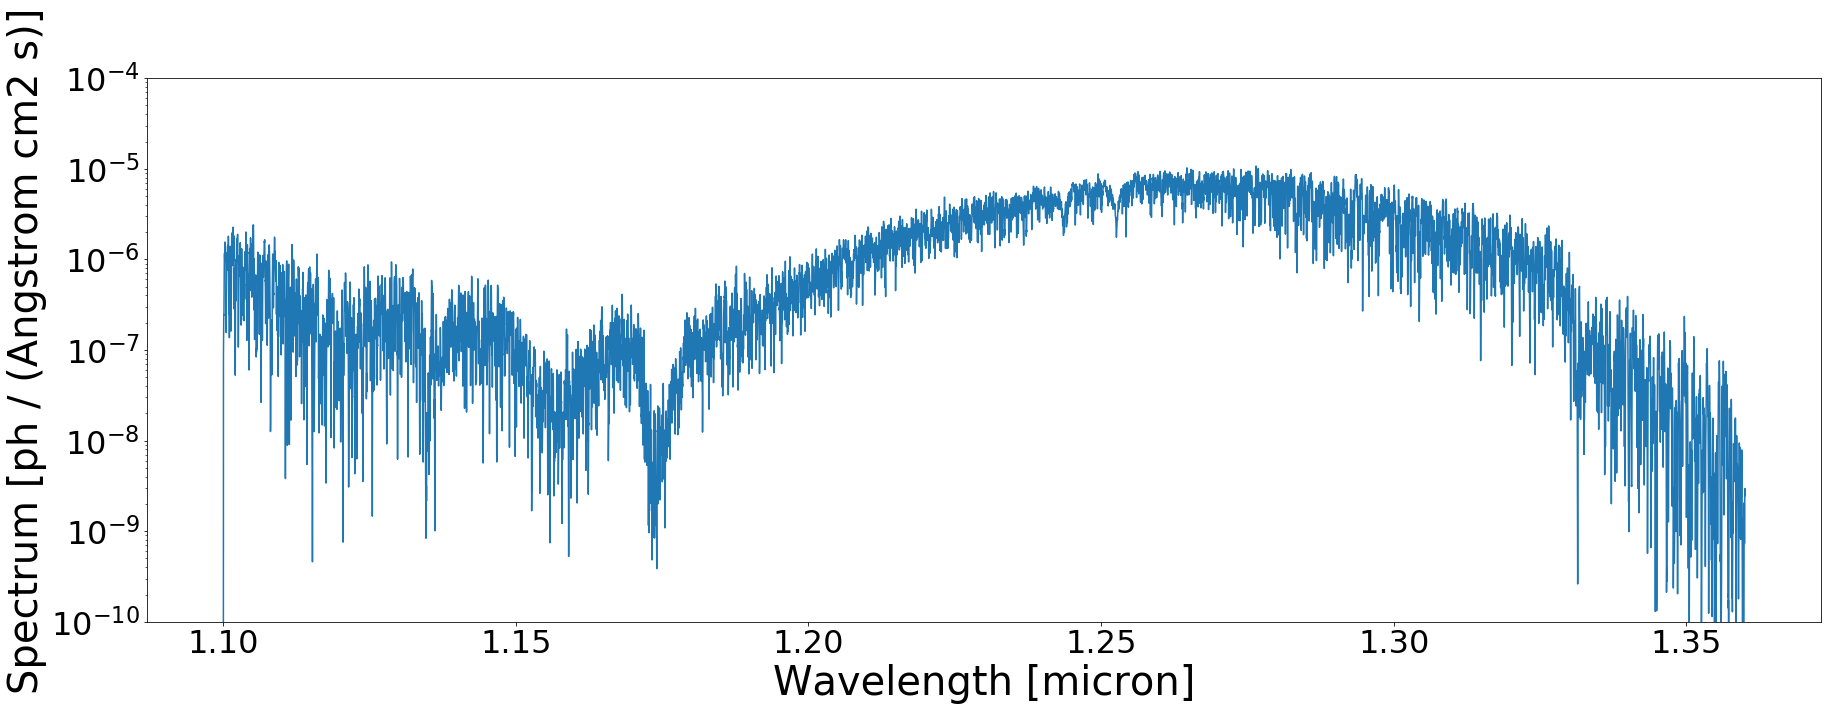

In [8]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spectrum)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spectrum.unit))
plt.ylim(1e-10,1e-4)

### Because of the original PSISIM design considerations, we want the object spectrum in contrast units

In [9]:
obj_spectrum /= host_spectrum

/home/dechever/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dechever/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


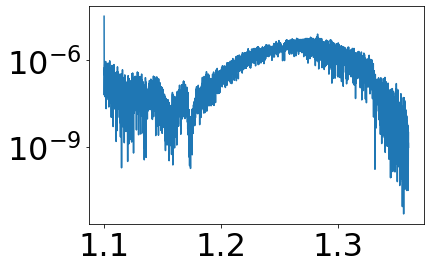

In [10]:
plt.semilogy(wavelengths,obj_spectrum)

# Simulate an observation

First set some extra parameters

In [11]:
# The angular separation of the companion, in milliarcsecond
host_properties['AngSep'] = 400 

#Get the host star magnitude in the AO filter
host_properties["StarAOmag"] = spectrum.get_model_ABmags(host_properties,[hispec.ao_filter], model='Phoenix',
                                                         verbose=False,user_params = host_user_params)
hispec.ao_mag = host_properties["StarAOmag"]

#Hispec doesn't care about the spectral type, but we need to include teh paramter
host_properties['StarSpT'] = None

Actually simulate the observation 

In [12]:
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(keck,hispec,host_properties,
                                                                                      obj_spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                       post_processing_gain = 10,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False)

/home/dechever/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Plot it!

(0.0001, 200.0)

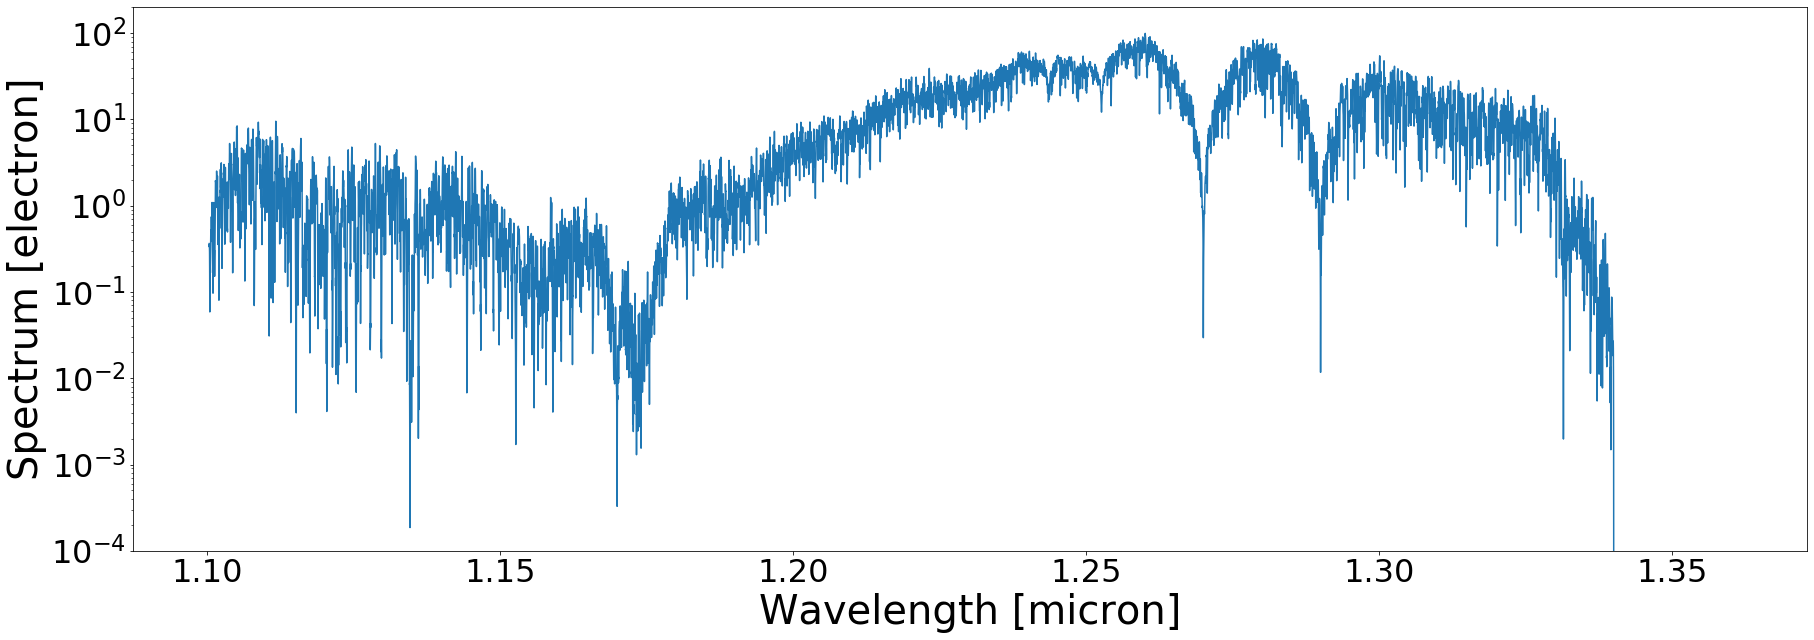

In [13]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
plt.ylim(1e-4,2e2)

## Now let's cycle through the available filters and collect all the results 

In [14]:
reload(observation)

<module 'psisim.observation' from '/home/dechever/Code/psisim/psisim/observation.py'>

In [15]:
all_wavelengths = []
full_host_spectrum = []
full_obj_spectrum = []
full_obj_spectrum_nosky = []
full_total_noise = []
full_thermal_spec = []
full_noise_components = []
full_speckle_noise = []


for hispec_filter in hispec.filters:
    
    #Setup the instrument
    hispec.set_current_filter(hispec_filter)
    wavelengths = hispec.get_wavelength_range()
    hispec.set_observing_mode(3600,1,hispec_filter, wavelengths) 
    
    
    host_user_params = (path,'TwoMASS-J',5.0,filters,hispec.current_filter)
    host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,hispec.current_R,
                                                  model="Phoenix",user_params=host_user_params,
                                                  doppler_shift=True,broaden=True,delta_wv=hispec.current_dwvs)
    
    obj_user_params = (path,'TwoMASS-K',20,filters,hispec.current_filter)
    obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,hispec.current_R,model="Sonora",
                                                 user_params=obj_user_params,doppler_shift=True,broaden=True,
                                                 delta_wv=hispec.current_dwvs)
    
    obj_spectrum /= host_spectrum
    
    obj_spec,total_noise,stellar_spec,thermal_spec,noise_components= observation.simulate_observation(keck,hispec,
                                                                                      host_properties,
                                                                                      obj_spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = 1.,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False,
                                                                                      no_speckle_noise=True,
                                                                                      plot=False)
    obj_spec_no_sky,_,_,_ = observation.simulate_observation_nosky(keck,hispec,
                                                                                      host_properties,
                                                                                      obj_spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = 1.,
                                                                                      return_noise_components=False,
                                                                                      stellar_spec=host_spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False,
                                                                                      no_speckle_noise=True,
                                                                                      plot=False)

    full_speckle_noise.append(hispec.get_speckle_noise(0.4*u.arcsecond,host_properties["StarAOmag"],hispec.current_filter,
                                             wavelengths,host_properties['StarSpT'],keck)[0])
    all_wavelengths.append(wavelengths)
    full_host_spectrum.append(stellar_spec)
    full_obj_spectrum.append(obj_spec)
    full_obj_spectrum_nosky.append(obj_spec_no_sky)
    full_total_noise.append(total_noise)
    full_thermal_spec.append(thermal_spec)
    full_noise_components.append(noise_components)

all_wavelengths = np.hstack(all_wavelengths).value*wavelengths.unit
full_host_spectrum = np.hstack(full_host_spectrum).value*stellar_spec.unit
full_obj_spectrum = np.hstack(full_obj_spectrum).value*obj_spec.unit
full_obj_spectrum_nosky = np.hstack(full_obj_spectrum_nosky).value*obj_spec_no_sky.unit
full_total_noise = np.hstack(full_total_noise).value*total_noise.unit
full_noise_components = np.hstack(full_noise_components)*obj_spec.unit
full_thermal_spec = np.hstack(full_thermal_spec).value*thermal_spec.unit
full_speckle_noise = np.hstack(full_speckle_noise)

/home/dechever/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dechever/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


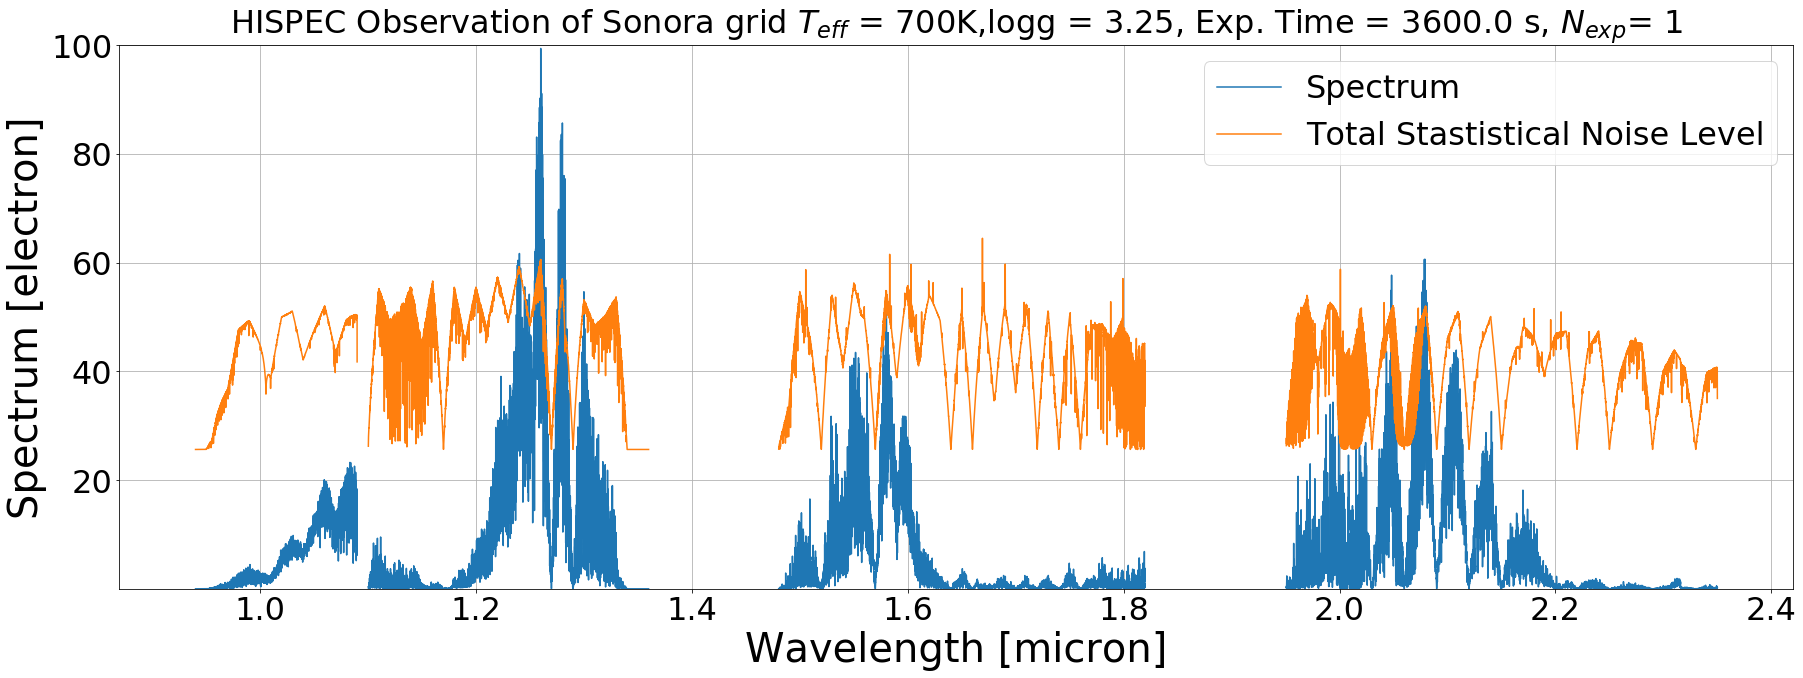

In [16]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum,label="Spectrum")
plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
plt.title(r"HISPEC Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"],obj_properties["StarLogg"],hispec.exposure_time,hispec.n_exposures))
plt.ylim(1e-4,1e2)
plt.grid()

## We can calculate the signal to noise now


(-0.1, 2.0)

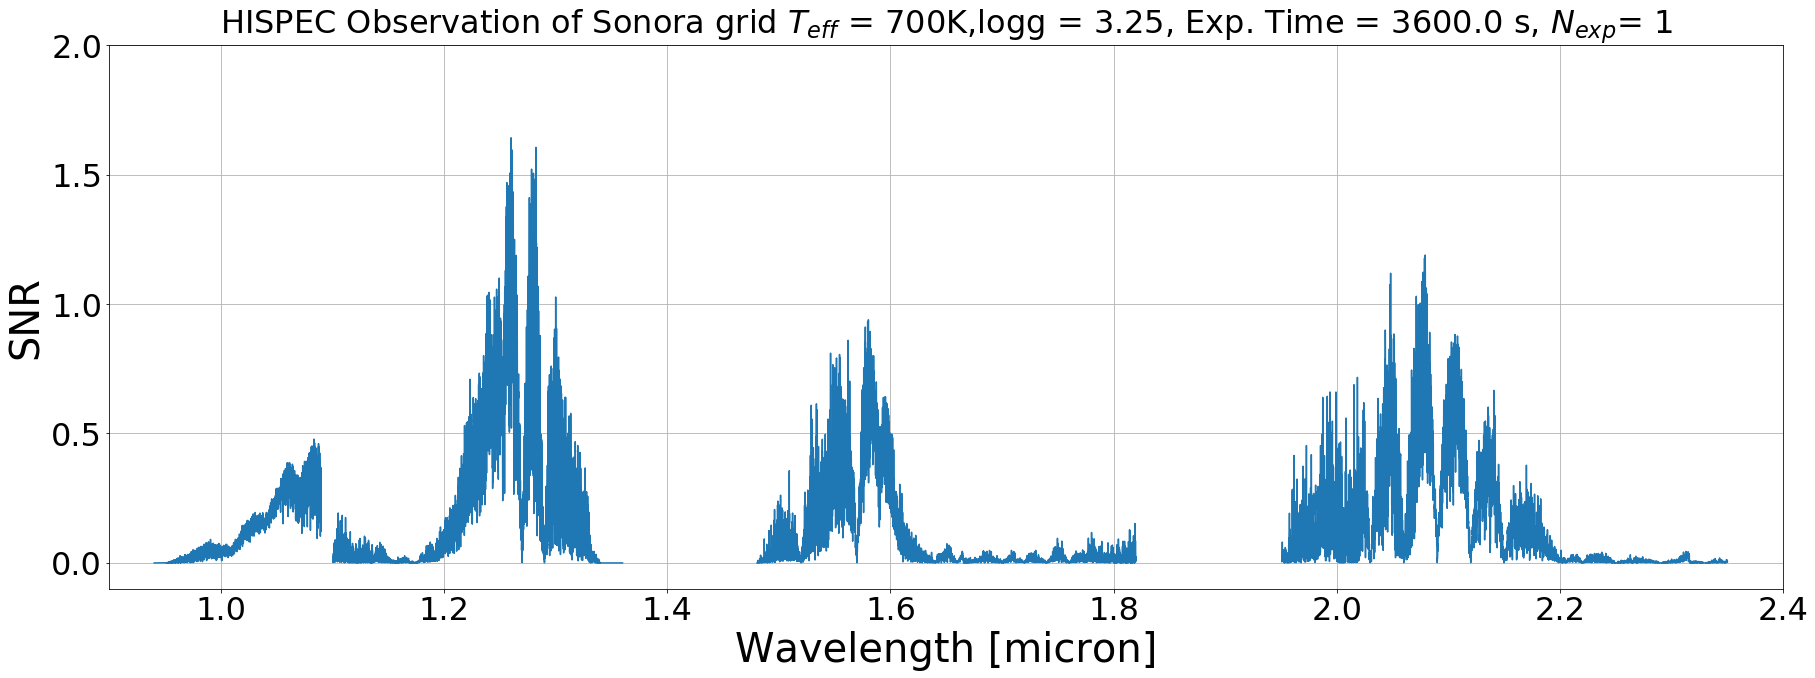

In [17]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum/full_total_noise)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("SNR")

plt.title(r"HISPEC Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"],obj_properties["StarLogg"],hispec.exposure_time,hispec.n_exposures))

# plt.ylim(-0.01,0.4)
plt.xlim(0.9,2.4)
plt.grid()
plt.ylim(-0.1,2.)

### But let's not forget about systematics. We will estimate our ability to remove the host star spectrum and the telluric lines at the 1% level. 

In [18]:
cal = 0.01 #Telluric calibration accuracy of 1%

#The photon flux at the object will be the stellar flux multipled by the contrast there: 
# full_host_spectrum
host_flux_at_obj = full_host_spectrum*hispec.get_speckle_noise(0.4*u.arcsecond,host_properties["StarAOmag"],
                                                               "",all_wavelengths,None,keck)[0]

systematics = (cal*(host_flux_at_obj+full_thermal_spec))**2 #Variance of systematics

noise_plus_systematics = np.sqrt(full_total_noise**2+systematics)

(-0.1, 2.0)

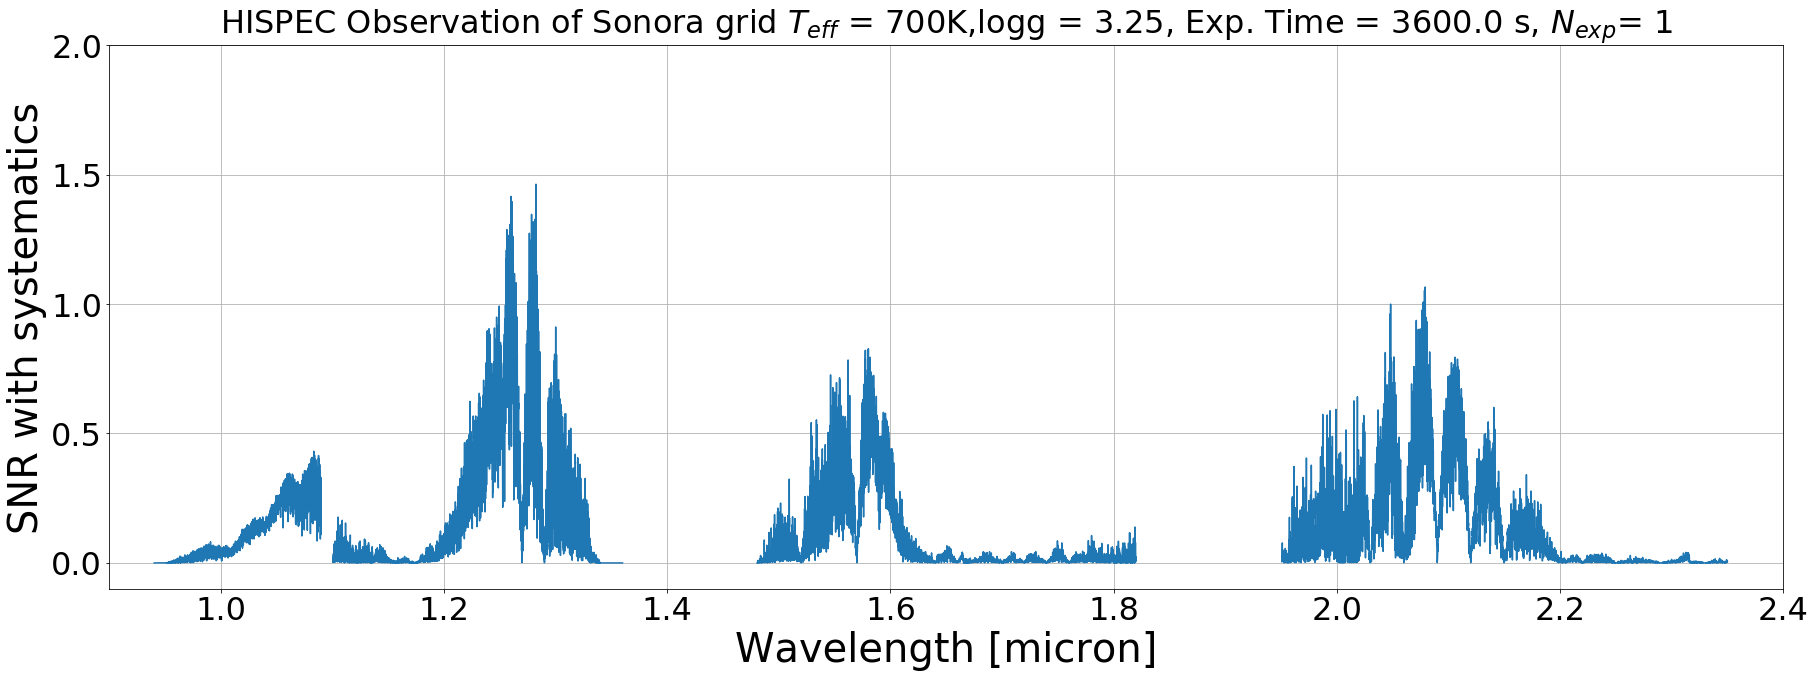

In [19]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum/noise_plus_systematics)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("SNR with systematics")

plt.title(r"HISPEC Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"],obj_properties["StarLogg"],hispec.exposure_time,hispec.n_exposures))

# plt.ylim(-0.01,0.4)
plt.xlim(0.9,2.4)
plt.grid()
plt.ylim(-0.1,2.)

## Calculate the CCF-SNR

### We'll do this with in the K-band (the last one from when we cycled through the filters above)

Since we're doing this in k-band we'll want to recalculate the noise with the systematics just for this band

In [20]:
cal = 0.01 #Telluric calibration accuracy of 1%

#The photon flux at the object will be the stellar flux multipled by the contrast there: 
# full_host_spectrum
host_flux_at_obj = stellar_spec*hispec.get_speckle_noise(0.4*u.arcsecond,host_properties["StarAOmag"],
                                                               "",wavelengths,None,keck)[0]

systematics = (cal*(host_flux_at_obj+thermal_spec))**2 #Variance of systematics

noise_plus_systematics = np.sqrt(total_noise**2+systematics)


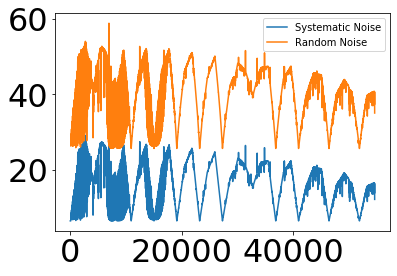

In [21]:
plt.plot(np.sqrt(systematics),label="Systematic Noise")
plt.plot(total_noise,label="Random Noise")
plt.legend(fontsize=10)

Calculate the sky transmission lines convolved with the line spread function

In [22]:
#Get the wavelength spacing
dwvs = np.abs(wavelengths - np.roll(wavelengths, 1))
dwvs[0] = dwvs[1]
dwv_mean = np.mean(dwvs)
lsf_fwhm = (hispec.lsf_width/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma

#Calculate the 
sky_transmission_lsf = gaussian_filter(keck.get_atmospheric_transmission(wavelengths),
                                                                           lsf_sigma.value)

Now get the ccf snr

In [23]:
ccf_snr = signal.compute_ccf_snr_matchedfilter(obj_spec, obj_spec_no_sky, noise_plus_systematics, 
                                            sky_transmission_lsf,
                                               systematics_residuals = cal, 
                                               norm_cutoff=0.8)
print(ccf_snr)

17.199369975258282 1 / electron


We can also calculate the ccf SNF for all the bands

# Some other things we can look at to compare with Dimitri's original notebook "HISPEC MODHIS ETC HDC v3"

#### The thermal spectrum of the sky, telecsope and instrument.

(0.9, 2.4)

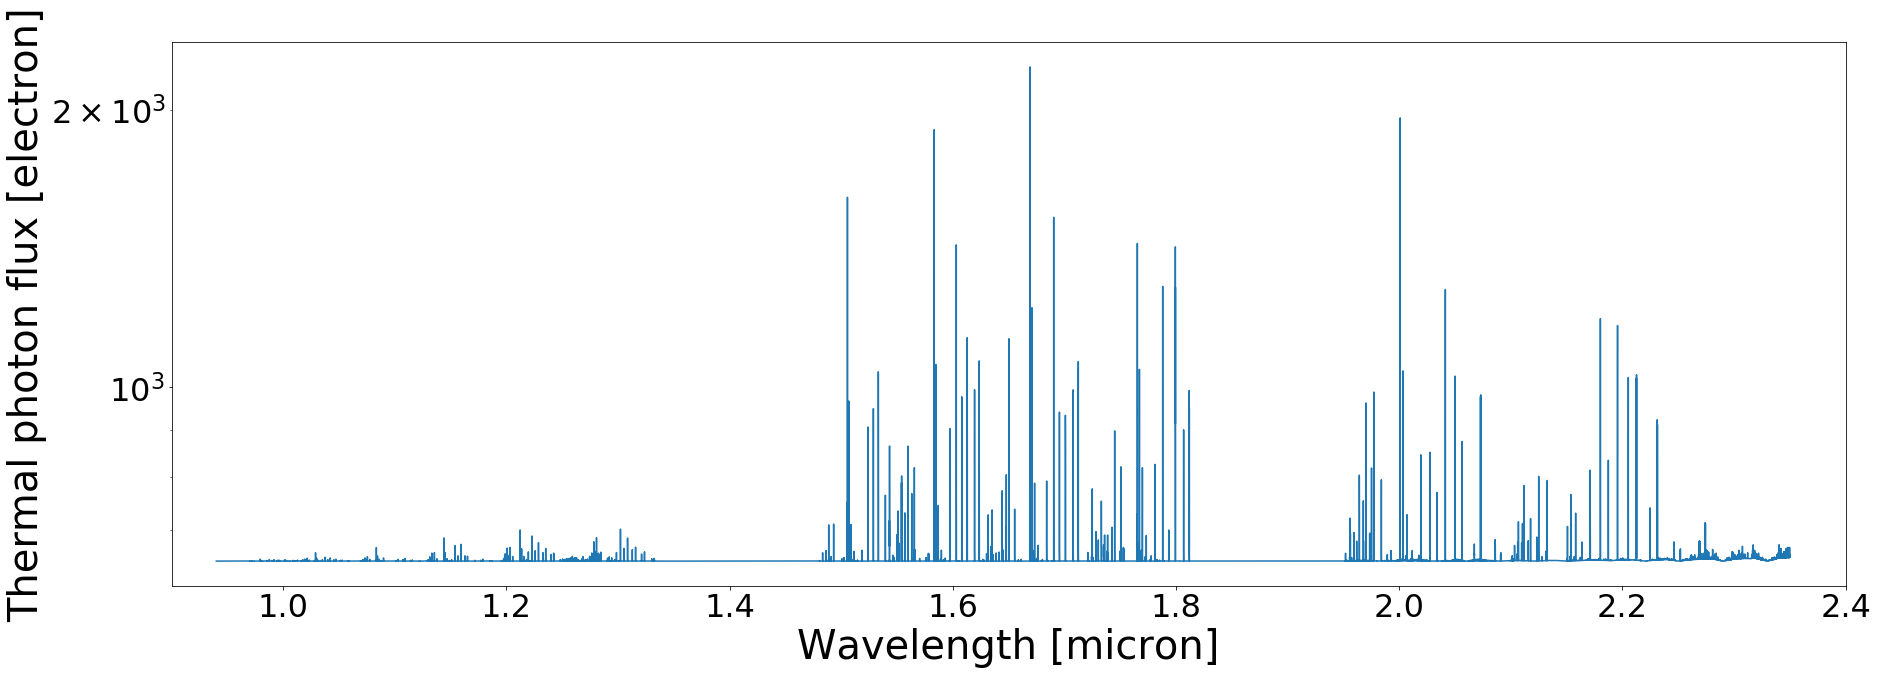

In [24]:
plt.figure(figsize=(30,10))

# plt.semilogy(all_wavelengths,full_host_spectrum)
plt.semilogy(all_wavelengths,full_thermal_spec)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel('Thermal photon flux [{}]'.format(str((full_thermal_spec).unit)))
# plt.ylim(1e,1e7)
# plt.ylim(1e4,1e8)
plt.xlim(0.9,2.4)


### What about the relative contributions of the different noise components

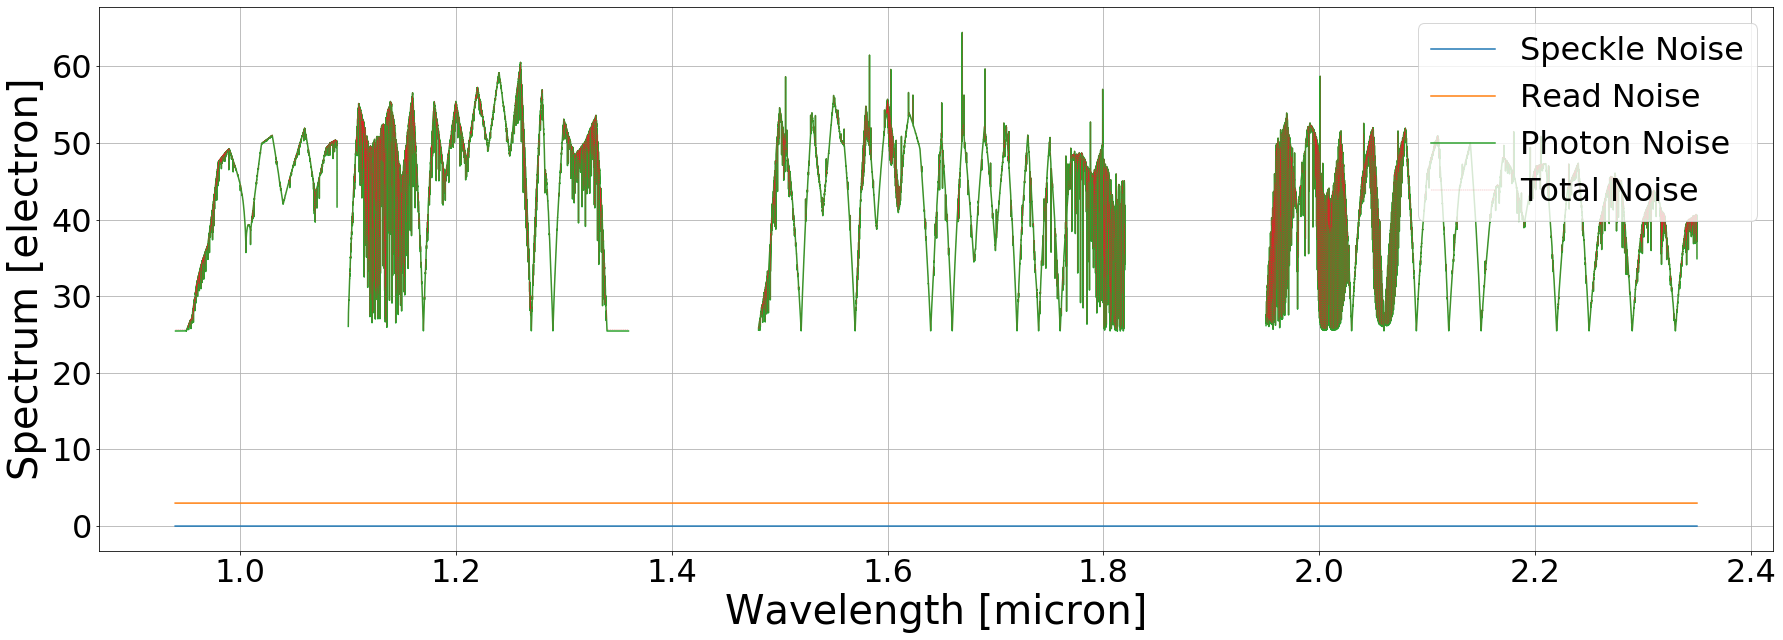

In [25]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_noise_components[0],label="Speckle Noise")
plt.plot(all_wavelengths,full_noise_components[1],label="Read Noise")
# plt.plot(all_wavelengths,full_noise_components[2],label="Dark Current Noise")
plt.plot(all_wavelengths,full_noise_components[2],label="Photon Noise")

plt.plot(all_wavelengths,full_total_noise,linestyle="-.",label="Total Noise",linewidth=0.2)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
# plt.ylim(1e0,5e1)
plt.grid()
plt.legend()

## We can also check the throughput of the system: 

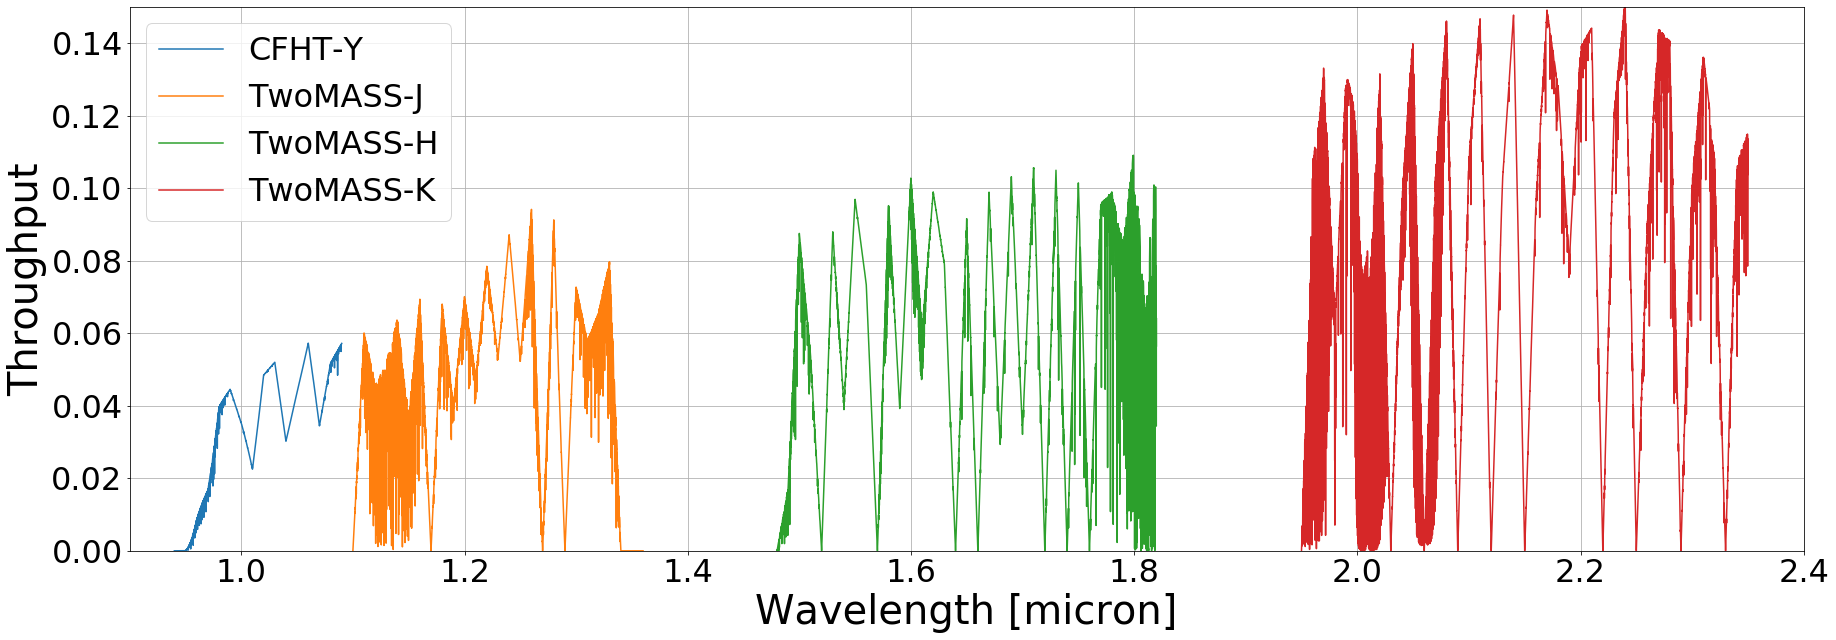

In [26]:
th_sky = []
th_total = []
SR = []

fig = plt.figure(figsize=(30,10))

for hispec_filter in hispec.filters:    
    #Setup the instrument
    hispec.set_current_filter(hispec_filter)
    wavelengths = hispec.get_wavelength_range()
    hispec.set_observing_mode(3600,1,hispec_filter, wavelengths) 
    
    
    th_sky.append(keck.get_atmospheric_transmission(wavelengths))
    th_total.append(keck.get_telescope_throughput(wavelengths,hispec)*hispec.get_inst_throughput(wavelengths)*hispec.get_filter_transmission(wavelengths,hispec.current_filter))
    SR.append(hispec.compute_SR(wavelengths))            
    
    plt.plot(wavelengths,0.95*keck.get_atmospheric_transmission(wavelengths)*keck.get_telescope_throughput(wavelengths,hispec)*hispec.get_inst_throughput(wavelengths)*hispec.get_filter_transmission(wavelengths,hispec.current_filter),label=hispec_filter)
    
#     print(np.mean(hispec.current_dwvs))

th_sky = np.hstack(th_sky)
th_total = np.hstack(th_total)
SR = np.hstack(SR)

plt.xlim(0.9,2.4)
plt.ylim(0,0.15)
plt.grid()
plt.xlabel("Wavelength [micron]")
plt.ylabel("Throughput")

plt.legend()

## And the Strehl Ratio

(0.9, 2.4)

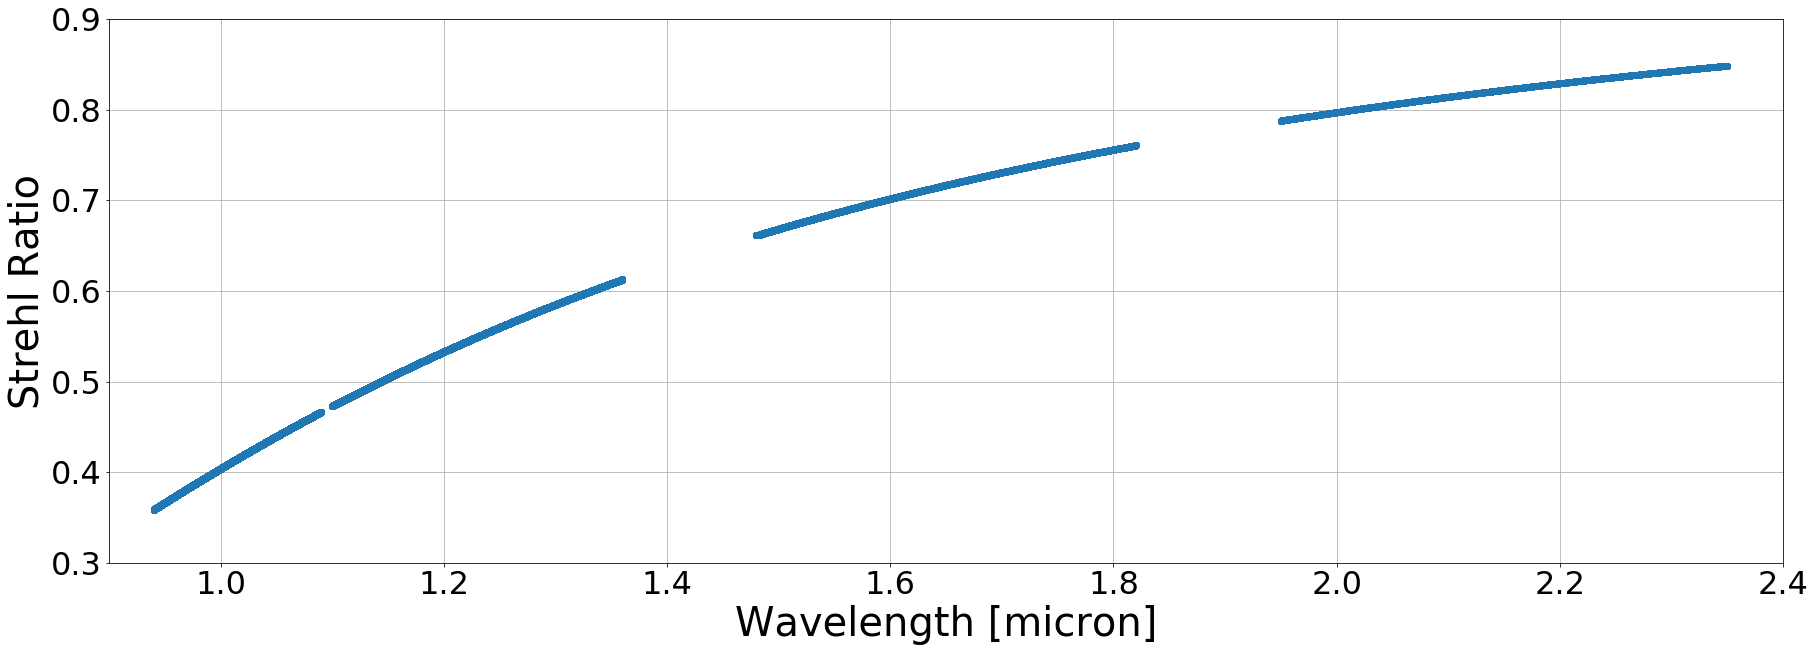

In [27]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,SR,'o')

# plt.ylim(1e-2,0.2)
plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Strehl Ratio")
# plt.ylim(1e-4,1e2)
plt.grid()
plt.ylim(0.3,0.9)
plt.xlim(0.9,2.4)

## Check the contrasts and mark the 0.4 arcsecond location for each wavelength

/home/dechever/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(1e-05, 0.001)

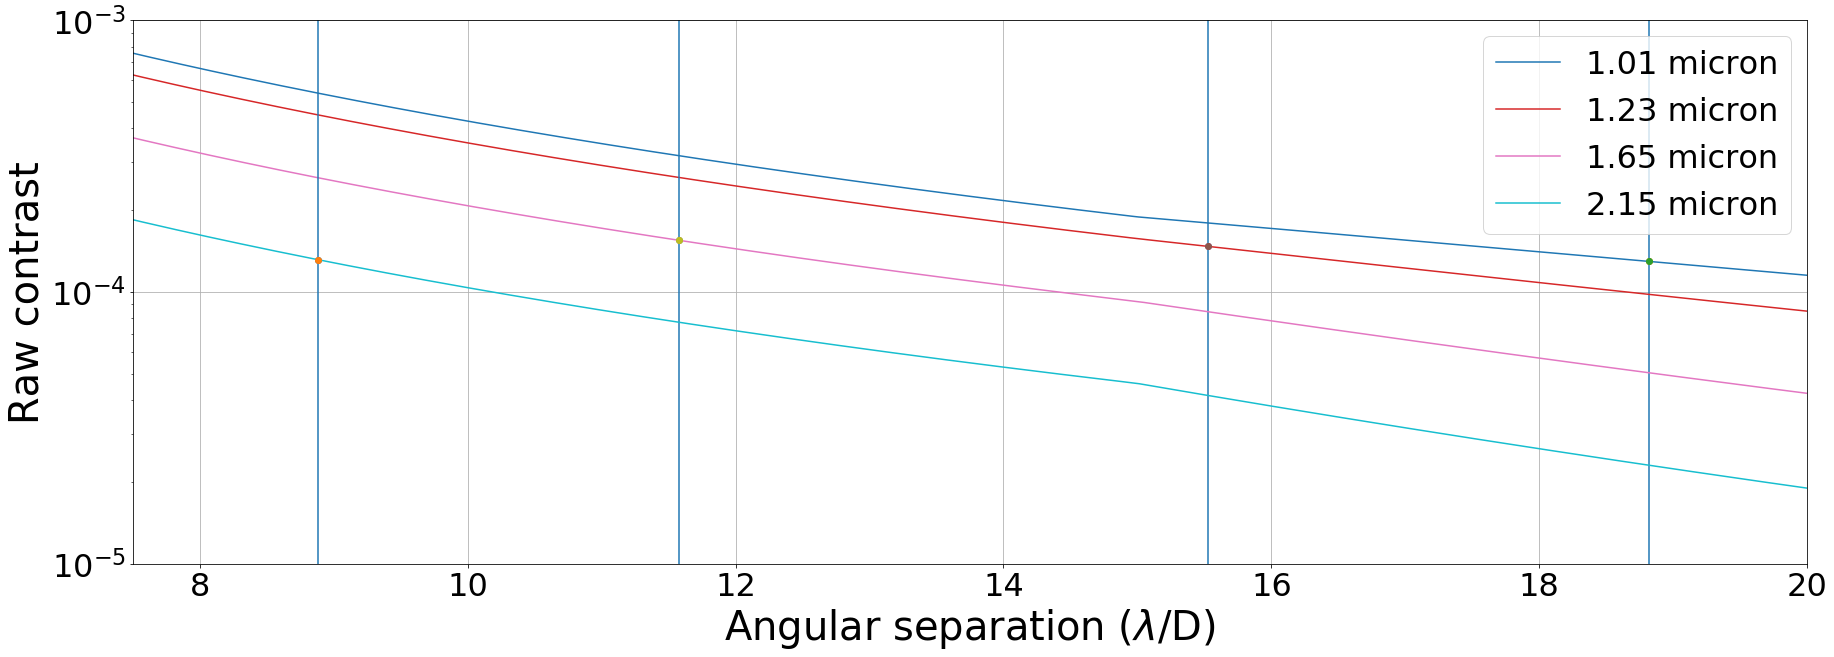

In [28]:
separations = np.arange(0,1.,0.001)*u.arcsecond

plt.figure(figsize=(30,10))

for hispec_filter in hispec.filters:
    
    hispec.set_current_filter(hispec_filter)
    wavelengths = hispec.get_wavelength_range()
    hispec.set_observing_mode(3600,1,hispec_filter, wavelengths) 
    
#     print(wavelengths[int(wavelengths.shape[0]/2):int(wavelengths.shape[0]/2)+2])
    
    contrasts = hispec.get_speckle_noise(separations,host_properties["StarAOmag"],hispec.current_filter,
                                       wavelengths[int(wavelengths.shape[0]/2):int(wavelengths.shape[0]/2)+2],
                                         host_properties['StarSpT'],keck)[:,0]
    
    tsts = hispec.get_speckle_noise(np.array([0.4,0.5,0.6])*u.arcsecond,host_properties["StarAOmag"],
                                       hispec.current_filter,
                                       wavelengths[int(wavelengths.shape[0]/2):int(wavelengths.shape[0]/2)+2],
                                       host_properties['StarSpT'],keck)[0]
    
    plt.semilogy(separations/206265*keck.diameter/np.mean(wavelengths).to(u.m),contrasts,
                 label="{:.2f}".format(np.mean(wavelengths)))
    plt.axvline(0.4/206265*keck.diameter/np.mean(wavelengths).to(u.m))
    plt.plot([0.4/206265*keck.diameter/np.mean(wavelengths).to(u.m)],[tsts],'o')
    
# plt.xlim([0.01,100])
# plt.ylim([1e-7,1])
plt.xlabel('Angular separation ($\lambda$/D)')
plt.ylabel('Raw contrast')
plt.legend()

plt.grid(True)
plt.xlim(7.5,20)
plt.ylim(1e-5,1e-3)

## Cross Correlating Noisy Spectra with Model

In [29]:
y = 0.94/1e5/3; j = 1.248 / 1e5 /3; h = 1.633 / 1e5 / 3; k = 2.200 / 1e5 / 3
exp_time = 3600 * u.s
delta_lb = np.array([y, j, h, k])*u.micron
samp = np.array([3,3,3,3])

## code to split the arrays for nicer plots. not necessary but splits plots into 4 filters
wavesplit = np.array([all_wavelengths[97:44205],all_wavelengths[44301:106705],all_wavelengths[106803:168167],all_wavelengths[169262::]])
flux_split = np.array([host_flux_at_obj[97:44205],host_flux_at_obj[44301:106705],host_flux_at_obj[106803:168167],host_flux_at_obj[169262::]])
thermal_flux_split = np.array([full_thermal_spec[97:44205],full_thermal_spec[44301:106705],full_thermal_spec[106803:168167],full_thermal_spec[169262::]])
obj_spec_split = np.array([full_obj_spectrum[97:44205].value,full_obj_spectrum[44301:106705].value,full_obj_spectrum[106803:168167].value,full_obj_spectrum[169262::].value])
ron_split = np.array([full_noise_components[1][97:44205],full_noise_components[1][44301:106705],full_noise_components[1][106803:168167],full_noise_components[1][169262::]])
sky_trans_split = np.array([sky_transmission_lsf[97:44205],sky_transmission_lsf[44301:106705],sky_transmission_lsf[106803:168167],sky_transmission_lsf[169262::]])
model_spec_split= np.array([full_obj_spectrum_nosky[97:44205],full_obj_spectrum_nosky[44301:106705],full_obj_spectrum_nosky[106803:168167],full_obj_spectrum_nosky[169262::]])

In [30]:
noisy_spec_filt, model_filt, ccf, ccf_model, velocity= signal.reduce_spec(wavesplit, delta_lb, samp, obj_spec_split, model_spec_split,flux_split, thermal_flux_split, ron_split, exp_time, sky_trans_split,cal, 301, 0.5)
for i in range(obj_spec_split.shape[0]):
    plt.figure(figsize=(30,10))
    plt.plot(wavesplit[i],model_filt[i], label='Model')
    plt.plot(wavesplit[i],noisy_spec_filt[i], label='Data',alpha=0.5)
    #plt.title(fac+'. Host: '+str(host_mag)+' mag (Vega, ' + host_filt +'), '+str(host_temp)+'K star')
    plt.xlabel('Wavelength (micron)')
    plt.ylabel('Noisy spectrum reduced, filtered')
    plt.legend()
    
    plt.figure(figsize=(30,10))
    plt.plot(velocity[i],ccf_model[i], label='Model ACF')
    plt.plot(velocity[i],ccf[i], label='CCF data with model')
    plt.xlim([-100,100])
    #plt.title(fac+'. Host: '+str(host_mag)+' mag (Vega, ' + host_filt +'), '+str(host_temp)+'K star')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Correlation')
    plt.legend()

AttributeError: 'numpy.ndarray' object has no attribute 'unit'

## Plot Spectra with Features

In [ ]:
for i in range(noisy_spec_filt.shape[0]):
    signal.plot_features(wavesplit[i],model_filt[i],noisy_spec_filt[i],features=['h2o','ch4','co','na','ca','vo','feh','k','h'])

## Compute PRV Accuracy

In [ ]:
#need to double check math
snr = full_obj_spectrum/full_total_noise
sigma_rv = signal.compute_prv_sigma(wavesplit, delta_lb, snr, model_spec_split, sky_trans_split, cal, 101)